In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Import Perceval and Scaleway provider
import perceval as pcvl
import perceval.providers.scaleway as scw

# Import custom modules (if available)
from boson_sampler import BosonSampler
from utils import MNIST_partial, plot_training_metrics

import keras
import tensorflow as tf

In [2]:
# Set Scaleway project credentials (replace with actual values or ensure environment is set)
os.environ["SCW_PROJECT_ID"] = "5303a5ba-7e81-41a8-bcaf-937620e6dea6"
os.environ["SCW_SECRET_KEY"] = "7ec92326-858b-4275-b147-2e09351fbde9"

scw_project_id = os.environ.get("SCW_PROJECT_ID")
scw_token = os.environ.get("SCW_SECRET_KEY")
if scw_project_id is None or scw_token is None:
    raise ValueError("Please set SCW_PROJECT_ID and SCW_SECRET_KEY environment variables.")

def create_session():
    s = scw.Session(
        project_id=scw_project_id,
        token=scw_token,
        platform="sim:sampling:l4",
        max_idle_duration_s=4800,
        max_duration_s=10800,
        deduplication_id="my-photonic-session-pool"
    )
    s.start()
    return s

num_sessions = 20

sessions = [create_session() for _ in range(num_sessions)]
print("Scaleway session started.")


Scaleway session started.


In [3]:
sessions

In [4]:
# Define dataset paths (assuming MNIST .npy files are available)
root_path = "/Users/soardr/Desktop/Perceval/Photonic Kernel/data original"  # Update to the actual data directory
raw_train_path = os.path.join(root_path, "train_images.npy")
raw_test_path = os.path.join(root_path, "test_images.npy")

raw_train_path, raw_test_path


('/Users/soardr/Desktop/Perceval/Photonic Kernel/data original/train_images.npy',
 '/Users/soardr/Desktop/Perceval/Photonic Kernel/data original/test_images.npy')

In [5]:
# ('/path/to/Photonic Kernel/data/train_images.npy',
#  '/path/to/Photonic Kernel/data/test_images.npy')


In [6]:
# Experiment parameters
n_epochs = 30
n_layers = 7
PREPROCESS = True

np.random.seed(0)


In [7]:
def encoding_layer(data, type=2, kernel_size=2):
    assert data is not None
    if type == 1:
        modes = kernel_size ** 2
    elif type == 2:  # delayed encoding
        modes = kernel_size ** 2
        if (modes % 2) == 1:
            modes += 1
        modes //= 2

    circuit = pcvl.Circuit(modes)

    if type == 1:
        # Encoding each pixel value as a phase shift on a separate mode
        for i, pixel in enumerate(data):
            circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
        # Add beam splitters in a chain to entangle modes
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass

    elif type == 2:
        # Delayed encoding: first half of phase shifts, then BS, then remaining phase shifts
        for i, pixel in enumerate(data):
            if (i % 2) == 0:
                circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        for i, pixel in enumerate(data):
            if (i % 2) == 1:
                circuit.add(i % modes, pcvl.PS(2 * np.pi * pixel))
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass

    return circuit, modes

def post_encoding(circuit, modes, depth=2):
    """Apply additional layers of beam splitters to the circuit to increase mixing (entanglement)."""
    # A permutation (here identity) can be applied between layers (placeholder, currently identity)
    perm = list(range(modes))
    circuit.add(0, pcvl.PERM(perm))
    for _ in range(depth - 1):
        for i in range(modes):
            circuit.add(i, pcvl.PS(2 * np.pi / (2 ** (_ + 1))))

        for i in range(0, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        
        for i in range(1, modes, 2):
            try:
                circuit.add((i, (i + 1) % modes), pcvl.BS())
            except Exception:
                pass
        perm = list(range(modes))
        circuit.add(0, pcvl.PERM(perm))
    
    # Final layer of beam splitters
    for i in range(0, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass
    for i in range(1, modes, 2):
        try:
            circuit.add((i, (i + 1) % modes), pcvl.BS())
        except Exception:
            pass


In [8]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def generate_quantum_embedding(classical_data, modes=25, depth=2, session=None):
    MAX_EMBEDDING_DIM = 1000

    # Build the encoding circuit and apply additional mixing
    encode_circuit, modes_ret = encoding_layer(classical_data)
    post_encoding(encode_circuit, modes_ret, depth=depth)

    # Try to use remote quantum processor (Scaleway)
    try:
        if session is None:
            raise RuntimeError("No remote session available, using local simulation.")
        processor = session.build_remote_processor()
        processor.set_circuit(encode_circuit)
        # Input state: 10 photons in the first 10 modes (if modes_ret < 10, this will be adjusted below)
        input_state = [1] * min(10, modes_ret) + [0] * max(0, (modes_ret - 10))
        processor.with_input(pcvl.BasicState(input_state))

        n_samples = 1000

        sampler = pcvl.algorithm.Sampler(processor, max_shots_per_call=n_samples)
        job = sampler.probs(n_samples)
        raw_distribution = job.get("results")
        if raw_distribution is None:
            raise ValueError("Remote job returned no results.")
    except Exception as e:
        # If the session is terminated or not available, perform local simulation (simplified)
        if session is not None and "session is terminated" in str(e):
            print("Session terminated. Restarting session...")
            session.start()
            processor = session.build_remote_processor()
            processor.set_circuit(encode_circuit)
            processor.with_input(pcvl.BasicState(input_state))
            sampler = pcvl.algorithm.Sampler(processor, max_shots_per_call=n_samples)
            job = sampler.probs(n_samples)
            raw_distribution = job.get("results")
        else:
            # Local simulation of interference (fallback)
            a, b, c, d = classical_data  # expects a list of 4 pixel values
            # Phase shifts for each pixel
            E0 = complex(np.cos(2*np.pi*a), np.sin(2*np.pi*a))
            E1 = complex(np.cos(2*np.pi*b), np.sin(2*np.pi*b))
            E2 = complex(np.cos(2*np.pi*c), np.sin(2*np.pi*c))
            E3 = complex(np.cos(2*np.pi*d), np.sin(2*np.pi*d))
            # First layer of beam splitters (mix 0-1 and 2-3)
            E0p = (E0 + E1) / np.sqrt(2)
            E1p = (E0 - E1) / np.sqrt(2)
            E2p = (E2 + E3) / np.sqrt(2)
            E3p = (E2 - E3) / np.sqrt(2)
            # Second layer of beam splitters (mix 0'-3' and 1'-2')
            E0pp = (E3p - E0p) / np.sqrt(2)
            E3pp = (E3p + E0p) / np.sqrt(2)
            E1pp = (E1p + E2p) / np.sqrt(2)
            E2pp = (E1p - E2p) / np.sqrt(2)
            # Output "quantum" features as intensities
            I0 = E0pp.real**2 + E0pp.imag**2
            I1 = E1pp.real**2 + E1pp.imag**2
            I2 = E2pp.real**2 + E2pp.imag**2
            I3 = E3pp.real**2 + E3pp.imag**2
            # Use these four features as a simple embedding
            emb_tensor = torch.tensor([I0, I1, I2, I3], dtype=torch.float32)
            return emb_tensor
    
    # print("raw distribution in generate_quantum_embedding:", raw_distribution)

    # If using remote, convert the distribution to an embedding vector
    sorted_keys = sorted(raw_distribution.keys(), key=lambda k: raw_distribution[k], reverse=True)
    # print("sorted_keys in generate_quantum_embedding:", sorted_keys)

    sorted_keys = sorted_keys[:max(MAX_EMBEDDING_DIM, len(sorted_keys))]
    # print("sorted_keys after proc in generate_quantum_embedding:", generate_quantum_embedding)

    embedding_vector = np.zeros(max(MAX_EMBEDDING_DIM, len(sorted_keys)))
    for idx, key in enumerate(sorted_keys):
        embedding_vector[idx] = raw_distribution[key]
    emb_tensor = torch.tensor(embedding_vector, dtype=torch.float32)
    print("Quantum embedding generated with shape:", emb_tensor.shape)
    print("emb_tensor")
    
    return emb_tensor


In [18]:
import concurrent.futures

In [19]:
num_sessions

20

In [20]:
def quanv_inner(image, j, W, out, output_channels, session):
    for k in range(0, W, 2):
        patch = [
            float(image[j, k, 0]),
            float(image[j, k + 1, 0]),
            float(image[j + 1, k, 0]),
            float(image[j + 1, k + 1, 0])
        ]
        # Get quantum embedding for this 2x2 patch
        q_emb = generate_quantum_embedding(patch, session=session)
        q_emb = q_emb.detach().numpy() if torch.is_tensor(q_emb) else np.array(q_emb)
        # print("q_emb in quanv_perceval:", q_emb, q_emb.shape)
        # Use first 4 features for the output feature map
        out[j // 2, k // 2, :output_channels] = q_emb[:output_channels]

In [25]:
def quanv_perceval(image, sessions, local_idx):
    """Apply the photonic quantum convolution to a single image."""
    H, W, C = image.shape
    assert C == 1  # expecting a single-channel (grayscale) image
    output_channels = 20

    out = np.zeros((H // 2, W // 2, output_channels))
    # Slide a 2x2 window across the image with stride 2

    # threading
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
        futures = {executor.submit(quanv_inner, image, i * 2, W, out, output_channels, sessions[i]): i for i in range(14)}

        # # Collect results
        # for future in concurrent.futures.as_completed(futures):
        #     # print(future.result())
        #     temp = future.result()
        #     q_test_images.append(temp[1])
        #     q_test_labels.append(temp[0])
    
    # for j in range(0, H, 2):
    #     for k in range(0, W, 2):
    #         patch = [
    #             float(image[j, k, 0]),
    #             float(image[j, k + 1, 0]),
    #             float(image[j + 1, k, 0]),
    #             float(image[j + 1, k + 1, 0])
    #         ]
    #         # Get quantum embedding for this 2x2 patch
    #         q_emb = generate_quantum_embedding(patch, session=sessions[j])
    #         q_emb = q_emb.detach().numpy() if torch.is_tensor(q_emb) else np.array(q_emb)
    #         # print("q_emb in quanv_perceval:", q_emb, q_emb.shape)
    #         # Use first 4 features for the output feature map
    #         out[j // 2, k // 2, :output_channels] = q_emb[:output_channels]
    
    return (local_idx, out)


In [58]:
# # Load the dataset from .npy files
# train_images = np.load(raw_train_path)
# test_images = np.load(raw_test_path)
# # (Optional) Load labels if available
# train_labels_path = os.path.join(root_path, "train_labels.npy")
# test_labels_path = os.path.join(root_path, "test_labels.npy")
# if os.path.exists(train_labels_path):
#     train_labels = np.load(train_labels_path)
#     test_labels = np.load(test_labels_path)
# else:
#     # # If label files are not present, use torchvision to download MNIST labels as a fallback
#     # train_labels = torchvision.datasets.MNIST(root="./data", train=True, download=True).targets.numpy()
#     # test_labels = torchvision.datasets.MNIST(root="./data", train=False, download=True).targets.numpy()

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images
train_labels = train_labels
test_images = test_images
test_labels = test_labels

# Normalize image pixel values to [0,1]
train_images = train_images / 255.0
test_images = test_images / 255.0
# Add channel dimension
train_images = train_images[..., np.newaxis]  # shape: (N_train, 28, 28, 1)
test_images = test_images[..., np.newaxis]    # shape: (N_test, 28, 28, 1)

print("Loaded data shapes:", train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)


Loaded data shapes: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [59]:
import concurrent.futures

In [62]:
# Quantum feature extraction on training and test images
q_train_images = []
q_train_labels = []

q_test_images = []
q_test_labels = []

SAVE_PATH = "./"  # save in current directory or specify a path

# if PREPROCESS:
# for kkk in range(5):
if True:
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        # For demonstration, we limit to a smaller number of images to avoid long runtimes
        if idx >= 31:  # process first 100 images for example
        # if True:
            if (idx + 1) % 10 == 0:
                print(f"Processed {idx+1}/{len(train_images)} images", end="\r")
            
            temp = quanv_perceval(img, sessions, idx)
            q_train_images.append(temp[1])
            q_train_labels.append(temp[0])

            q_train_images = np.asarray(q_train_images)
            q_train_labels = np.asarray(q_train_labels)

            np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___train_images_cont_" + str(idx) + ".npy", q_train_images)
            np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___train_labels_cont_" + str(idx) + ".npy", q_train_labels)

            q_train_images = []
            q_train_labels = []
        else:
            pass
    
    # # for idx in range(0, 100, num_sessions):
    # # for idx in range(kkk * num_sessions, (kkk + 1) * num_sessions):
    # #     idxs = [idx + __ for __ in range(num_sessions)]
    # #     imgs = [train_images[i] for i in idxs]

    # #     # threading
    # #     with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
    # #         futures = {executor.submit(quanv_perceval, imgs[i], sessions[i], idxs[i]): i for i in range(num_sessions)}

    # #         # Collect results
    # #         for future in concurrent.futures.as_completed(futures):
    # #             # print(future.result())
    # #             temp = future.result()
    # #             q_train_images.append(temp[1])
    # #             q_train_labels.append(temp[0])

    # # q_train_images = np.asarray(q_train_images)
    # # q_train_labels = np.asarray(q_train_labels)

    # # np.save(SAVE_PATH + "percv_emb_conv_type_1_train_images.npy", q_train_images)
    # # np.save(SAVE_PATH + "percv_emb_conv_type_1_train_labels.npy", q_train_labels)

    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        if idx >= 2:  # process first 20 test images for example
        # if True:
            if (idx + 1) % 10 == 0:
                print(f"Processed {idx+1}/{len(test_images)} images", end="\r")
            
            temp = quanv_perceval(img, sessions, idx)
            q_test_images.append(temp[1])
            q_test_labels.append(temp[0])

            q_test_images = np.asarray(q_test_images)
            q_test_labels = np.asarray(q_test_labels)

            np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___test_images_cont_" + str(idx) + ".npy", q_test_images)
            np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___test_labels_cont_" + str(idx) + ".npy", q_test_labels)

            q_test_images = []
            q_test_labels = []
        else:
            pass
    
    # for idx in range(0, 20, num_sessions):
    # for idx in range(kkk * num_sessions, (kkk + 1) * num_sessions):
    #     idxs = [idx + __ for __ in range(num_sessions)]
    #     imgs = [test_images[i] for i in idxs]

    #     # threading
    #     with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
    #         futures = {executor.submit(quanv_perceval, imgs[i], sessions[i], idxs[i]): i for i in range(num_sessions)}

    #         # Collect results
    #         for future in concurrent.futures.as_completed(futures):
    #             # print(future.result())
    #             temp = future.result()
    #             q_test_images.append(temp[1])
    #             q_test_labels.append(temp[0])
    
    # q_test_images = np.asarray(q_test_images)
    # q_test_labels = np.asarray(q_test_labels)

     # Save the quantum-processed images to disk for future use (optional)

    # np.save(SAVE_PATH + "percv_emb_conv_type_1_train_images_" + str(kkk) + ".npy", q_train_images)
    # np.save(SAVE_PATH + "percv_emb_conv_type_1_test_images_" + str(kkk) + ".npy", q_test_images)

    # np.save(SAVE_PATH + "percv_emb_conv_type_1_test_images.npy", q_test_images)
    # np.save(SAVE_PATH + "percv_emb_conv_type_1_test_labels.npy", q_test_labels)

#  # Save the quantum-processed images to disk for future use (optional)
# SAVE_PATH = "./"  # save in current directory or specify a path
# np.save(SAVE_PATH + "percv_emb_conv_type_1_train_images.npy", q_train_images)
# np.save(SAVE_PATH + "percv_emb_conv_type_1_test_images.npy", q_test_images)

# np.save(SAVE_PATH + "percv_emb_conv_type_1_train_labels.npy", q_train_labels)
# np.save(SAVE_PATH + "percv_emb_conv_type_1_test_labels.npy", q_test_labels)


Quantum pre-processing of train images:
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the met

KeyboardInterrupt: 

Quantum embedding generated with shape: torch.Size([1000])
emb_tensor
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
Quantum embedding generated with shape: torch.Size([1000])
emb_tensor
Quantum embedding generated with shape: torch.Size([1000])
emb_tensor
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current

In [ ]:
# # Quantum feature extraction on training and test images
# q_train_images = []
# q_train_labels = []

# q_test_images = []
# q_test_labels = []

# # if PREPROCESS:
# for kkk in range(100):
#     print("Quantum pre-processing of train images:")
#     # for idx, img in enumerate(train_images):
#     #     # For demonstration, we limit to a smaller number of images to avoid long runtimes
#     #     if idx < 100:  # process first 100 images for example
#     #         if (idx + 1) % 10 == 0:
#     #             print(f"Processed {idx+1}/{len(train_images)} images", end="\r")
#     #         q_train_images.append(quanv_perceval(img))
#     #     else:
#     #         break
    
#     # for idx in range(0, 100, num_sessions):
#     # for idx in range(kkk * num_sessions, (kkk + 1) * num_sessions):
#     if True:
#         idx = kkk * num_sessions
#         idxs = [idx + __ for __ in range(num_sessions)]
#         imgs = [train_images[i] for i in idxs]

#         # threading
#         with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
#             futures = {executor.submit(quanv_perceval, imgs[i], sessions[i], idxs[i]): i for i in range(num_sessions)}

#             # Collect results
#             for future in concurrent.futures.as_completed(futures):
#                 # print(future.result())
#                 temp = future.result()
#                 q_train_images.append(temp[1])
#                 q_train_labels.append(temp[0])

#     q_train_images = np.asarray(q_train_images)
#     q_train_labels = np.asarray(q_train_labels)

#     print("\nQuantum pre-processing of test images:")
#     # for idx, img in enumerate(test_images):
#     #     if idx < 1:  # process first 20 test images for example
#     #         if (idx + 1) % 10 == 0:
#     #             print(f"Processed {idx+1}/{len(test_images)} images", end="\r")
#     #         q_test_images.append(quanv_perceval(img))
#     #     else:
#     #         break
    
#     # for idx in range(0, 20, num_sessions):
#     # for idx in range(kkk * num_sessions, (kkk + 1) * num_sessions):
#     if True:
#         idx = kkk * num_sessions
#         idxs = [idx + __ for __ in range(num_sessions)]
#         imgs = [test_images[i] for i in idxs]

#         # threading
#         with concurrent.futures.ThreadPoolExecutor(max_workers=num_sessions) as executor:
#             futures = {executor.submit(quanv_perceval, imgs[i], sessions[i], idxs[i]): i for i in range(num_sessions)}

#             # Collect results
#             for future in concurrent.futures.as_completed(futures):
#                 # print(future.result())
#                 temp = future.result()
#                 q_test_images.append(temp[1])
#                 q_test_labels.append(temp[0])
    
#     q_test_images = np.asarray(q_test_images)
#     q_test_labels = np.asarray(q_test_labels)

#      # Save the quantum-processed images to disk for future use (optional)
#     SAVE_PATH = "./"  # save in current directory or specify a path
#     np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___train_images_" + str(kkk) + ".npy", q_train_images)
#     np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___test_images_" + str(kkk) + ".npy", q_test_images)

#     np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___train_labels_" + str(kkk) + ".npy", q_train_labels)
#     np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___test_labels_" + str(kkk) + ".npy", q_test_labels)

#     q_train_images = []
#     q_train_labels = []

#     q_test_images = []
#     q_test_labels = []

#     # # Save the quantum-processed images to disk for future use (optional)
#     # SAVE_PATH = "./"  # save in current directory or specify a path
#     # np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___train_images.npy", q_train_images)
#     # np.save(SAVE_PATH + "percv_emb_conv_type_2__PS_BS_perm___test_images.npy", q_test_images)


Quantum pre-processing of train images:
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the method processor.min_detected_photons_filter(value) before any call of processor.with_input(input). The current deduced value of min_detected_photons is 2
[warning] Setting a value for min_detected_photons will soon be mandatory, please change your scripts accordingly. Use the met

KeyboardInterrupt: 

### Reading the embeddings

In [35]:
perc_type2_train_img_emb = np.load("percv_emb_conv_type_2__PS_BS_perm___train_images.npy")
perc_type2_test_img_emb = np.load("percv_emb_conv_type_2__PS_BS_perm___test_images.npy")

In [37]:
perc_type2_train_lbl_emb = np.load("percv_emb_conv_type_2__PS_BS_perm___train_labels.npy")
perc_type2_test_lbl_emb = np.load("percv_emb_conv_type_2__PS_BS_perm___test_labels.npy")

In [36]:
perc_type2_train_img_emb.shape, perc_type2_test_img_emb.shape

((10, 14, 14, 20), (2, 14, 14, 20))

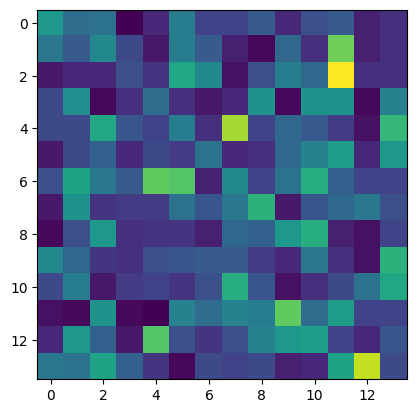

In [33]:
plt.imshow(perc_type2_train_img_emb[0][:, :, 0])

### Dataset creation

In [38]:
train_images = torch.tensor(perc_type2_train_img_emb, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (10, 20, 14, 14)
train_labels = torch.tensor(perc_type2_train_lbl_emb, dtype=torch.long)

In [39]:
test_images = torch.tensor(perc_type2_test_img_emb, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (10, 20, 14, 14)
test_labels = torch.tensor(perc_type2_test_lbl_emb, dtype=torch.long)

In [43]:
expanded_images_train = train_images.reshape(-1, 14, 14, 1)  # (10 × 20, 14, 14, 1)
expanded_labels_train = np.repeat(train_labels, 20)  # Repeat each label 20 times

# Convert to torch tensors
expanded_images_train = torch.tensor(expanded_images_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
expanded_labels_train = torch.tensor(expanded_labels_train, dtype=torch.long)

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2801/942005330.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_images_train = torch.tensor(expanded_images_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2801/942005330.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_labels_train = torch.tensor(expanded_labels_train, dtype=torch.long)


In [44]:
expanded_images_test = test_images.reshape(-1, 14, 14, 1)  # (10 × 20, 14, 14, 1)
expanded_labels_test = np.repeat(test_labels, 20)  # Repeat each label 20 times

# Convert to torch tensors
expanded_images_test = torch.tensor(expanded_images_test, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
expanded_labels_test = torch.tensor(expanded_labels_test, dtype=torch.long)

/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2801/2577248847.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_images_test = torch.tensor(expanded_images_test, dtype=torch.float32).permute(0, 3, 1, 2)  # (200, 1, 14, 14)
/var/folders/3x/956gglvx6tbcvyg7m0dghx8r0000gq/T/ipykernel_2801/2577248847.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expanded_labels_test = torch.tensor(expanded_labels_test, dtype=torch.long)


In [40]:
import torch.utils.data as data

In [41]:
# Create a custom dataset
class QuantumMNISTDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [51]:
dataset = QuantumMNISTDataset(expanded_images_train, expanded_labels_train)
dataloader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [55]:
# Define a simple CNN model
class QuantumMNISTClassifier(nn.Module):
    def __init__(self):
        super(QuantumMNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(20, 32, kernel_size=3, padding=1)  # (20 channels → 32 filters)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class QuantumMNISTClassifierV2(nn.Module):
    def __init__(self):
        super(QuantumMNISTClassifierV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)  # (1 → 16 filters)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)  # (16 → 32 filters)
        self.pool = nn.MaxPool2d(2, 2)  # Downsamples to (7x7)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=2)
        # self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Fully connected layer
        self.fc1 = nn.Linear(128, 64)  # Fully connected layer
        self.fc2 = nn.Linear(64, 10)  # Output layer (10 classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = QuantumMNISTClassifierV2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    correct, total = 0, 0
    
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/100, Loss: 2.3341, Accuracy: 7.00%
Epoch 2/100, Loss: 2.3227, Accuracy: 10.00%
Epoch 3/100, Loss: 2.2990, Accuracy: 8.50%
Epoch 4/100, Loss: 2.3072, Accuracy: 9.00%
Epoch 5/100, Loss: 2.2870, Accuracy: 10.00%
Epoch 6/100, Loss: 2.3263, Accuracy: 10.00%
Epoch 7/100, Loss: 2.3022, Accuracy: 7.50%
Epoch 8/100, Loss: 2.3046, Accuracy: 8.00%
Epoch 9/100, Loss: 2.3077, Accuracy: 10.00%
Epoch 10/100, Loss: 2.3190, Accuracy: 9.00%
Epoch 11/100, Loss: 2.3143, Accuracy: 9.50%
Epoch 12/100, Loss: 2.3129, Accuracy: 10.00%
Epoch 13/100, Loss: 2.3053, Accuracy: 10.00%
Epoch 14/100, Loss: 2.3034, Accuracy: 6.00%
Epoch 15/100, Loss: 2.2926, Accuracy: 7.00%
Epoch 16/100, Loss: 2.3075, Accuracy: 9.00%
Epoch 17/100, Loss: 2.3054, Accuracy: 8.00%
Epoch 18/100, Loss: 2.3037, Accuracy: 10.00%
Epoch 19/100, Loss: 2.2983, Accuracy: 7.50%
Epoch 20/100, Loss: 2.3066, Accuracy: 8.50%
Epoch 21/100, Loss: 2.3034, Accuracy: 4.50%
Epoch 22/100, Loss: 2.2981, Accuracy: 10.00%
Epoch 23/100, Loss: 2.3046, Accur

In [48]:
len(dataset)

200

### Vanilla Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

def MyModel():
    """Initializes and returns a simple Keras model for classification."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),  # flatten input (no Conv layers here)
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Initialize two models: one for quantum features, one for original features
q_model = MyModel()
c_model = MyModel()


In [ ]:
# Train on quantum features
q_history = q_model.fit(
    q_train_images, train_labels[:len(q_train_images)],  # use corresponding labels for the processed subset
    validation_data=(q_test_images, test_labels[:len(q_test_images)]),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

# Train on original images (baseline)
c_history = c_model.fit(
    train_images[:len(q_train_images)], train_labels[:len(q_train_images)],  # use same number of samples for fair comparison
    validation_data=(test_images[:len(q_test_images)], test_labels[:len(q_test_images)]),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)


## Combined

In [63]:
fully_combined = None

In [64]:
def append_npy_files(final_file, new_files):
    if os.path.exists(final_file):
        existing_data = np.load(final_file, allow_pickle=True)
    else:
        existing_data = np.array([])  # Start with an empty array
    
    for new_file in new_files:
        new_data = np.load(new_file, allow_pickle=True)
        
        # Concatenate along the first axis (assuming shape consistency)
        if existing_data.size == 0:
            existing_data = new_data
        else:
            existing_data = np.concatenate((existing_data, new_data), axis=0)
    
    np.save(final_file, existing_data)
    print(f"Appended {len(new_files)} files. Final dataset shape: {existing_data.shape}")

In [65]:
new_files = ["/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_images.npy"]

In [66]:
for i in range(10, 53):
    new_files.append("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_images_cont_" + str(i) + ".npy")

In [67]:
append_npy_files("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_images__final_concat.npy", new_files)

Appended 44 files. Final dataset shape: (53, 14, 14, 20)


In [68]:
new_files = ["/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_labels.npy"]

In [69]:
for i in range(10, 53):
    new_files.append("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_labels_cont_" + str(i) + ".npy")

In [70]:
append_npy_files("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_labels__final_concat.npy", new_files)

Appended 44 files. Final dataset shape: (53,)


In [71]:
np.save("/Users/soardr/Desktop/Perceval/Photonic Kernel/percv_emb_conv_type_2__PS_BS_perm___train_labels__final_concat__2.npy", train_labels[:53])